In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

In [3]:
def inverse(f, domain=(0.0, 1.0-1e-6), extrapolate=(float("NaN"), float("NaN"))):
    def inner(x):
        if f(domain[0]) >= x:
            return extrapolate[0]
        if f(domain[1]) <= x:
            return extrapolate[1]
        else:
            try:
                return scipy.optimize.brentq(lambda y: f(y)-x, a=domain[0], b=domain[1])
            except ValueError:
                return float("NaN")

    return np.vectorize(inner)

import scipy.misc
def derivative(f, dx=1e-6):
    return np.vectorize(lambda x: scipy.misc.derivative(f, x, dx))

def G_L(p, L):
    sum = 0
    for i in range(1,len(p)):
        j = i - 1
        sum += p[j] * L[i] - p[i] * L[j]
    return sum
    
def G_U(p, L):
    pass


# Empirical Lorenz curves

## Lorenz curve observed at a finite set of points

If the Lorenz curve is defined empirically, we have an increasing sequence of points $p_i, i = 1..K$ with corresponding increasing $L_i = L(p_i)$. We assume also that $\mathsf{E}(y)$ is given. What then can we say about the income distribution?

First, such a sequence does not uniquely identify the Lorenz curve (or, therefore, the cdf or pdf). Consider a very simple example where only two interior points of the curve are given $(0.4, 0.16)$ and $(0.8, 0.64)$. This is equivalent to a table such as the following:

| Quantile   | Mean income |
|------------|-------------|
| lower 40%  |    \$4      |
| middle 40% |    \$12     |
| upper 20%  |    \$18     |

But these points do not uniquely identify the Lorenz curve. For example, we can fit both a quadratic and a quartic polynomial to these points.

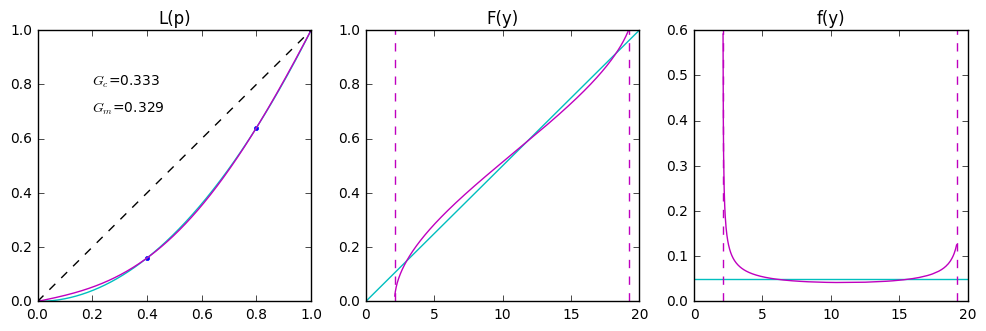

In [4]:
##########################################
plt.rcParams["figure.figsize"] = (12,3.5)
fig, ax = plt.subplots(1, 3)
##########################################

# Observed points of the Lorenz curve and population parameters
p = [0.0, 0.4,  0.8,  1.0]
L = [0.0, 0.16, 0.64, 1.0]
mean = 10.0
population = 100

# Grids for plotting
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 2*mean, 1000)

ax[0].plot(p, L, '.')

# Quadratic fit - transformations calculated analytically beforehand
# L(p) = p**2
quadratic_lorenz = lambda p: np.power(p, 2)                
quadratic_quantile = lambda p: mean * 2 * p                # Q(p) = mean * 2p
quadratic_cdf = lambda y: (1/2)*(y/mean)                   # F(y) = 1/2 (y / mean)
quadratic_pdf = lambda y: np.full(y.shape, (1/2)*(1/mean)) # f(y) = 1 / (2*mean)
quadratic_Gini = 2*(0.5 - ((1/3)*1**3 - (1/3*0**3)))

ax[0].plot(x, quadratic_lorenz(x),'c-')
ax[0].text(0.2, 0.8, "$G_c$={}".format(np.round(quadratic_Gini,3)))
ax[1].plot(y, quadratic_cdf(y), 'c-')
ax[2].plot(y, quadratic_pdf(y), 'c-');

# Quartic fit - transformations calculated numerically
# L(p) = (-25/38) p**4 + (55/38) p**3 + (4/19) p
quartic_lorenz = np.vectorize(lambda p: np.power(p, 4)*(-25/38.0) + np.power(p,3)*(55/38.0) + p*(4/19.0))
quartic_quantile = lambda p: mean*derivative(quartic_lorenz)(p)
quartic_cdf = inverse(quartic_quantile)
quartic_pdf = derivative(quartic_cdf)
quartic_Gini = 1-2*scipy.integrate.quad(quartic_lorenz, 0.0, 1.0)[0]

ax[0].plot(x, quartic_lorenz(x), 'm-')
ax[0].text(0.2, 0.7, "$G_m$={}".format(np.round(quartic_Gini,3)))
ax[1].plot(y, quartic_cdf(y), 'm-')
ax[2].plot(y, quartic_pdf(y), 'm-')


##########################################
ymin = mean*derivative(quartic_lorenz)(0)
ymax = mean*derivative(quartic_lorenz)(1)
ax[1].axvline(ymin, color='m', linestyle='--')
ax[1].axvline(ymax, color='m', linestyle='--')
ax[2].axvline(ymin, color='m', linestyle='--')
ax[2].axvline(ymax, color='m', linestyle='--')

ax[0].plot((0,1),(0,1),"k--");

ax[0].set_title("L(p)")
ax[1].set_title("F(y)")
ax[2].set_title("f(y)");
##########################################


The cyan curve is a valid Lorenz curve (increasing, convex) that interpolates the points, but so is the magenta - with a different resulting income distribution. Looking at the plots, we might suppose that the tails of the distribution are particularly sensitive to the interpolation. And although the Gini coefficients for the two distributions are quite close (0.333 vs 0.329, the magenta curve being slightly more equal) other measures of inequality, that depend more heavily on the tails, may be vastly different. For example, the ratio of the bottom 1% to the median, $Q_{0.01}:Q_{0.50}$, is 0.02 for the magenta curve, but 0.22 for the cyan curve - ten times larger.

Clearly, to tie down the distribution, we need to impose further assumptions.

## Minimal piecewise linear

Even in this very narrow class of curves (piecewise linear with no more than 3 segments) we can construct three quite different Lorenz curves that interpolate the points given (and these are not exhaustive).

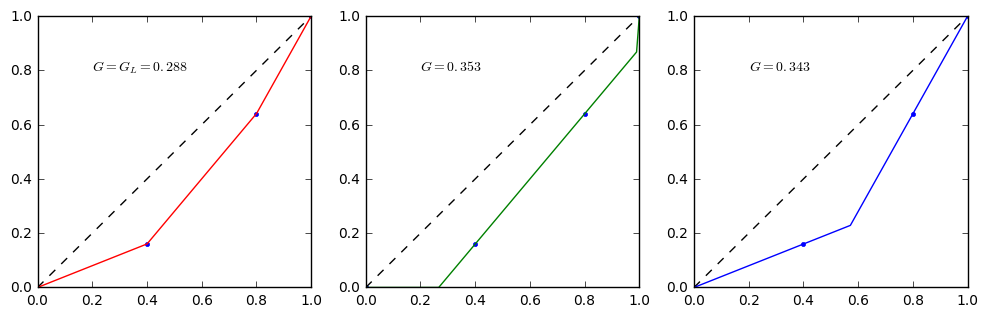

In [11]:
##########################################
plt.rcParams["figure.figsize"] = (12,3.5)
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
##########################################

from scipy.integrate import quad

# The 'straight' curve
interior_slope = (L[2]-L[1])/(p[2]-p[1])
bottom_intercept = p[1]-L[1]/interior_slope
right_intercept = L[2]+interior_slope*(1.0-(1.0/population)-p[2])
p_straight = [0.0,bottom_intercept,p[1],p[2],1.0-(1.0/population),1.0]
L_straight = [0.0,0.0,L[1],L[2],right_intercept,1.0]

# The 'triangle' curve
left_slope = L[1]/p[1]              # curve 1: L = left_slope * p
right_slope = (1.0-L[2])/(1.0-p[2]) # curve 2: L = 1.0 - right_slope * (1.0 - p)
middle_p = (1.0 - right_slope) / (left_slope - right_slope) # solve for p
middle_L = left_slope * middle_p
p_tri = [0.0,p[1],middle_p,p[2],1.0]
L_tri = [0.0,L[1],middle_L,L[2],1.0]

lorenz_natural = lambda z: np.interp(z, p, L)
lorenz_straight = lambda z: np.interp(z, p_straight, L_straight)
lorenz_triangle = lambda z: np.interp(z, p_tri, L_tri)

ax1.plot(p, L, '.')
ax1.plot((0,1),(0,1),"k--");
ax1.plot(x, lorenz_natural(x), 'r-')
Gini = 2*(0.5 - quad(lorenz_natural, 0, 1)[0])
ax1.text(0.2, 0.8, "$G=G_L={}$".format(np.round(Gini,3)))

ax2.plot(p, L, '.')
ax2.plot((0,1),(0,1),"k--");
ax2.plot(x, lorenz_straight(x), 'g-')
Gini = 2*(0.5 - quad(lorenz_straight, 0, 1)[0])
ax2.text(0.2, 0.8, "$G={}$".format(np.round(Gini,3)))

ax3.plot(p, L, '.')
ax3.plot((0,1),(0,1),"k--");
ax3.plot(x, lorenz_triangle(x), 'b-')
Gini = 2*(0.5 - quad(lorenz_triangle, 0, 1)[0])
ax3.text(0.2, 0.8, "$G={}$".format(np.round(Gini,3)));

Two of these curves have special significance. The red curve, the usual linear interpolation, results in the smallest Gini coefficient of all possible interpolations ($G_L$ in [Fuller, 1979](http://www.sciencedirect.com/science/article/pii/0165176579901150)). It seems likely that the green curve results, in the limit, in the largest Gini coefficient of all possible interpolations [haven't proved this].

These three curves result in quite different cdfs.

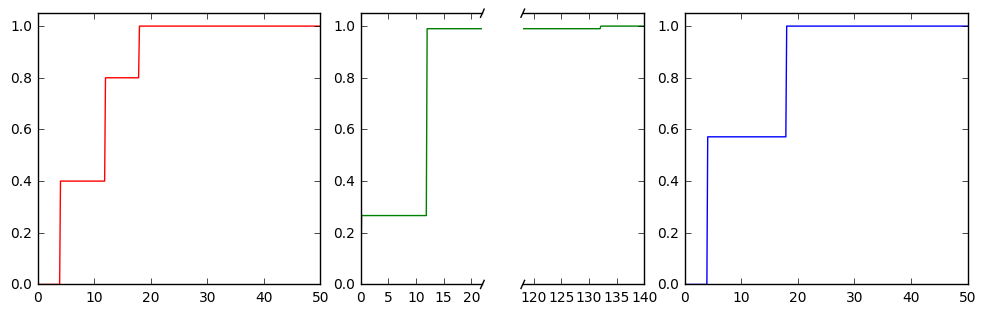

In [12]:
##########################################
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 3.5)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[1,0.43,0.43,1])
ax1 = plt.subplot(gs[0])
ax2a, ax2b = plt.subplot(gs[1]),plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
##########################################

y = np.linspace(0, mean*15, 1000)

quantile_natural = lambda z: mean * derivative(lorenz_natural)(z)
quantile_straight = lambda z: mean * derivative(lorenz_straight)(z)
quantile_triangle = lambda z: mean * derivative(lorenz_triangle)(z)
    
cdf_natural = inverse(quantile_natural, extrapolate=(0.0,1.0))
cdf_straight = inverse(quantile_straight, extrapolate=(0.0,1.0))
cdf_triangle = inverse(quantile_triangle, extrapolate=(0.0,1.0))
    
ax1.set_xlim((0, 50))
ax1.set_ylim((0, 1.05))
ax1.plot(y, cdf_natural(y), "r-")

ax3.set_xlim((0, 50))
ax3.set_ylim((0, 1.05))
ax3.plot(y, cdf_triangle(y), "b-")


ax2a.plot(y, cdf_straight(y), "g-")
ax2b.plot(y, cdf_straight(y), "g-")

ax2a.set_xlim((0, 22))
ax2b.set_xlim((118,140))
ax2a.set_ylim((0, 1.05))
ax2b.set_ylim((0, 1.05))
# hide the spines between ax and ax2
ax2a.spines['right'].set_visible(False)
ax2b.spines['left'].set_visible(False)
ax2a.yaxis.tick_left()
ax2b.yaxis.tick_right()
ax2b.tick_params(labelright=False)

d = .015  
kwargs = dict(transform=ax2a.transAxes, color='k', clip_on=False)
ax2a.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax2a.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2b.transAxes)
ax2b.plot((-d, + d), (1 - d, 1 + d), **kwargs)
ax2b.plot((-d, + d), (-d, +d), **kwargs)



Finally, since piecewise linear Lorenz curves have piecewise constant $L'(p)$ and so piecewise constant $Q(p)$ and $F(y)$, they have discrete probability functions, with atoms of positive probability. The three examples above have the following probability mass functions (the equivalent of densities for discrete variables).

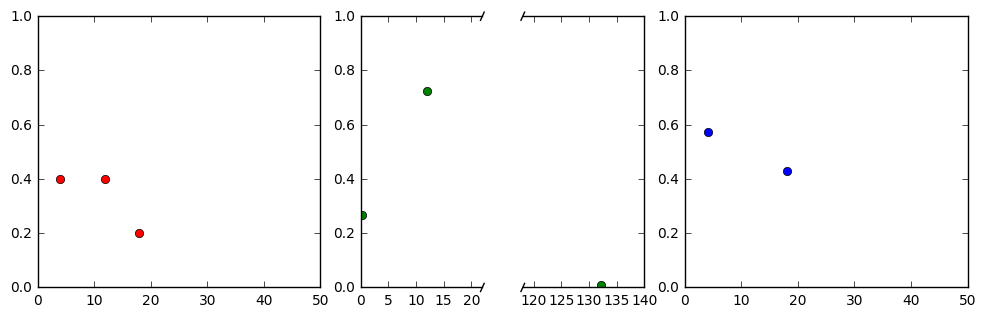

In [14]:
##########################################
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 3.5)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[1,0.43,0.43,1])
ax1 = plt.subplot(gs[0])
ax2a, ax2b = plt.subplot(gs[1]),plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
##########################################

dp = np.diff(cdf_natural(y))
dp[dp < 0.005] = np.nan # to hide numerical errors
ax1.plot(y[1:], dp, "ro")
ax1.set_ylim((0, 1.0))
ax1.set_xlim((0, 50))

dp = np.diff(cdf_triangle(y))
dp[dp < 0.005] = np.nan # to hide numerical errors
ax3.plot(y[1:], dp, "bo")
ax3.set_ylim((0, 1.0))
ax3.set_xlim((0, 50))
    
dp = np.diff(cdf_straight(y))
dp[dp < 0.005] = np.nan # to hide numerical errors
ax2a.plot(y[1:], dp, "go")
ax2b.plot(y[1:], dp, "go")
ax2a.set_xlim((0, 22))
ax2b.set_xlim((118,140))
ax2a.set_ylim((0, 1.0))
ax2b.set_ylim((0, 1.0))
# hide the spines between ax and ax2
ax2a.spines['right'].set_visible(False)
ax2b.spines['left'].set_visible(False)
ax2a.yaxis.tick_left()
ax2b.yaxis.tick_right()
ax2b.tick_params(labelright=False)

d = .015  
kwargs = dict(transform=ax2a.transAxes, color='k', clip_on=False)
ax2a.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax2a.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2b.transAxes)
ax2b.plot((-d, + d), (1 - d, 1 + d), **kwargs)
ax2b.plot((-d, + d), (-d, +d), **kwargs);
